# Init

In [1]:
%%time
import numpy as np
import pandas as pd

from datetime import datetime, timedelta 

import math
import matplotlib.pyplot as plt
%matplotlib nbagg

# To allow more outputs in Jupyter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Need to parse date with extra function because of the format
mydateparser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f')

# Path to left wrist, right wrist Actigraphy and Polysomnography data
path = "C:\\Users\\sigmu\\Desktop\\dataset\\"
l_ACG_file = "MECSLEEP60_left_wrist_018142_2015-05-21_15-31-30.csv"
r_ACG_file = "MECSLEEP60_right_wrist_018141_2015-05-21_15-32-02.csv"
PSG_file = "mecsleep60_psg.txt"

# Read files, name columns, put time stamp into index, skip rows to actual data
l_df = pd.read_csv(path+"Aktigrafie\\"+l_ACG_file, names=[
                 'time stamp', 'x axis [g]', 'y axis [g]', 'z axis [g]', 'light level [lux]', 'button [1/0]','temperature [°C]'], 
                 date_parser=mydateparser, index_col='time stamp', skiprows=100)
r_df = pd.read_csv(path+"Aktigrafie\\"+r_ACG_file, names=[
                 'time stamp', 'x axis [g]', 'y axis [g]', 'z axis [g]', 'light level [lux]', 'button [1/0]','temperature [°C]'], 
                 date_parser=mydateparser, index_col='time stamp', skiprows=100)

df_PSG = pd.read_csv(path+"Polysomnografie\\"+PSG_file, sep='\t', parse_dates=[2], 
                     index_col='Time [hh:mm:ss]', skiprows=17)

# Drop not needed columns
l_df.drop(columns=['light level [lux]', 'button [1/0]', 'temperature [°C]'], inplace=True, axis=1)
r_df.drop(columns=['light level [lux]', 'button [1/0]', 'temperature [°C]'], inplace=True, axis=1)
df_PSG.drop(columns=['Position', 'Event', 'Duration[s]'], inplace=True, axis=1)

# For writing out result
returns_path_csv = "C:\\Users\\sigmu\\Desktop\\dataset\\Aktigrafie\\test_write.csv"
returns_path_txt = "C:\\Users\\sigmu\\Desktop\\dataset\\Aktigrafie\\test_write.txt"
returns_path_xlsx = "C:\\Users\\sigmu\\Desktop\\dataset\\Aktigrafie\\test_write.xlsx"

Wall time: 5min 11s


# Cut ACG to match PSG timewise	

In [2]:
%%time
# Find ACG timestamp that matches PSG start, end
df_PSG_len = len(df_PSG.index)-1
df_len = len(l_df.index)

lbl_start = l_df[(l_df.index.hour == df_PSG.index[0].hour) & (l_df.index.minute == df_PSG.index[0].minute) & 
   (l_df.index.second == df_PSG.index[0].second)].index[0]
lbl_end = l_df[(l_df.index.hour == df_PSG.index[df_PSG_len].hour) & (l_df.index.minute == df_PSG.index[df_PSG_len].minute) & 
   (l_df.index.second == df_PSG.index[df_PSG_len].second)].index[0]

# Get index of start and end time stamp
idx_start = l_df.index.get_slice_bound(lbl_start, side ='right', kind ='getitem')
idx_end = l_df.index.get_slice_bound(lbl_end, side ='right', kind ='getitem')

# Drop everything else and create new df (df didn't work properly)
l_df_drp = l_df

l_df_drp = l_df_drp.drop(l_df.index[0:(idx_start-100)])
l_df_drp = l_df_drp.drop(l_df.index[(idx_end):(len(l_df.index))])
del l_df

#-------------------------------------------------------------------------------------------------
df_len = len(r_df.index)

lbl_start = r_df[(r_df.index.hour == df_PSG.index[0].hour) & (r_df.index.minute == df_PSG.index[0].minute) & 
   (r_df.index.second == df_PSG.index[0].second)].index[0]
lbl_end = r_df[(r_df.index.hour == df_PSG.index[df_PSG_len].hour) & (r_df.index.minute == df_PSG.index[df_PSG_len].minute) & 
   (r_df.index.second == df_PSG.index[df_PSG_len].second)].index[0]

idx_start = r_df.index.get_slice_bound(lbl_start, side ='right', kind ='getitem')
idx_end = r_df.index.get_slice_bound(lbl_end, side ='right', kind ='getitem')

r_df_drp = r_df

r_df_drp = r_df_drp.drop(r_df.index[0:(idx_start-100)])
r_df_drp = r_df_drp.drop(r_df.index[(idx_end):(len(r_df.index))])
del r_df

Wall time: 49.9 s


# 1. branch Resample in 5s epochs

In [3]:
# Resample by 5 second epoch and compute median of x,y,z
## origin... to match start of PSG
l_df_res = l_df_drp.resample('5S', origin=df_PSG.index[0]).median().round(decimals=4)
## first value was off
l_df_res.drop(l_df_res.index[0], inplace=True)

#-------------------------------------------------------------------------------------------------
r_df_res = r_df_drp.resample('5S', origin=df_PSG.index[0]).median().round(decimals=4)
r_df_res.drop(r_df_res.index[0], inplace=True)

# Compute angle

In [4]:
def comp_angle(row):
    return math.degrees(math.atan(row['z axis [g]'] / (row['x axis [g]']**2 + row['y axis [g]']**2)))

# Apply func comp_angle
l_df_res['angle'] = l_df_res.apply(comp_angle, axis=1).round(decimals=4)
# Return absolute difference in angle per column
l_df_res['abs angle change'] = l_df_res['angle'].diff().round(decimals=4).abs()
# New column all "W" 
l_df_res['State'] = "W"

#-------------------------------------------------------------------------------------------------
r_df_res['angle'] = r_df_res.apply(comp_angle, axis=1).round(decimals=4)
r_df_res['abs angle change'] = r_df_res['angle'].diff().round(decimals=4).abs()
r_df_res['State'] = "W"

# Inactivity

In [5]:
counter = 1
first_S = False

for index, value in l_df_res['abs angle change'].items():
    counter += 1
    
    # Angle change > 5
    if (value > 5):
        counter = 0
        l_df_res.loc[index, 'State'] = "W"
    # After first sleep - shorter threshold (1 min)   
    elif (counter > 12) & first_S:
        counter += 1
        l_df_res.loc[index, 'State'] = "S"
    # First sleep - longer threshold (5 min)
    elif (counter > 60):
        counter += 1
        l_df_res.loc[index, 'State'] = "S"
        first_S = True       
        
#-------------------------------------------------------------------------------------------------        
counter = 1
first_S = False

for index, value in r_df_res['abs angle change'].items():
    counter += 1
    
    # Angle change > 5
    if (value > 5):
        counter = 0
        r_df_res.loc[index, 'State'] = "W"
    # After first sleep - shorter threshold (1 min)   
    elif (counter > 12) & first_S:
        counter += 1
        r_df_res.loc[index, 'State'] = "S"
    # First sleep - longer threshold (5 min)
    elif (counter > 60):
        counter += 1
        r_df_res.loc[index, 'State'] = "S"
        first_S = True   

# Compare to PSG

In [6]:
# Resample to have same number of columns
l_df_res = l_df_res.resample('30S', origin=df_PSG.index[0]).interpolate()

#-------------------------------------------------------------------------------------------------       
r_df_res = r_df_res.resample('30S', origin=df_PSG.index[0]).interpolate()

In [7]:
# Overwrite sleep stage to bi-state and compare
l_df_res['Sleep Stage'] = np.where((df_PSG['Sleep Stage'] == 'N1')|(df_PSG['Sleep Stage'] == 'N2')|
                                 (df_PSG['Sleep Stage'] == 'N3')|(df_PSG['Sleep Stage'] == 'R'), 'S', 'W')

# create boolean column
l_df_res['match'] = np.where(l_df_res['State'] == l_df_res['Sleep Stage'], True, False)

#-------------------------------------------------------------------------------------------------
r_df_res['Sleep Stage'] = np.where((df_PSG['Sleep Stage'] == 'N1')|(df_PSG['Sleep Stage'] == 'N2')|
                                 (df_PSG['Sleep Stage'] == 'N3')|(df_PSG['Sleep Stage'] == 'R'), 'S', 'W')
r_df_res['match'] = np.where(r_df_res['State'] == r_df_res['Sleep Stage'], True, False)

In [8]:
# Number of rows and columns
l_df_res.shape

#  Returns relative frequency by dividing all values by the sum of values
l_df_res['match'].value_counts(normalize='True')

# Count True and False values
l_df_res['match'].values.sum()
(~l_df_res['match']).values.sum()

#-------------------------------------------------------------------------------------------------
r_df_res.shape
r_df_res['match'].value_counts(normalize='True')
r_df_res['match'].values.sum()
(~r_df_res['match']).values.sum()

(839, 8)

True     0.953516
False    0.046484
Name: match, dtype: float64

800

39

(839, 8)

True     0.945173
False    0.054827
Name: match, dtype: float64

793

46

# 2. branch Resample in 30s epochs

In [9]:
%%time
# Resample by 5 second epoch and compute median of x,y,z
## origin... to match start of PSG
l_df_res_30 = l_df_drp.resample('30S', origin=df_PSG.index[0]).median().round(decimals=4)
## first value was off
l_df_res_30.drop(l_df_res_30.index[0], inplace=True)

#-------------------------------------------------------------------------------------------------   
r_df_res_30 = r_df_drp.resample('30S', origin=df_PSG.index[0]).median().round(decimals=4)
r_df_res_30.drop(r_df_res_30.index[0], inplace=True)

Wall time: 394 ms


In [10]:
def comp_angle(row):
    return math.degrees(math.atan(row['z axis [g]'] / (row['x axis [g]']**2 + row['y axis [g]']**2)))

l_df_res_30['angle'] = l_df_res_30.apply(comp_angle, axis=1).round(decimals=4)
l_df_res_30['abs angle change'] = l_df_res_30['angle'].diff().round(decimals=4).abs()
l_df_res_30['State'] = "W"

#------------------------------------------------------------------------------------------------- 
r_df_res_30['angle'] = r_df_res_30.apply(comp_angle, axis=1).round(decimals=4)
r_df_res_30['abs angle change'] = r_df_res_30['angle'].diff().round(decimals=4).abs()
r_df_res_30['State'] = "W"

In [16]:
counter = 1
first_S = False

for index, value in l_df_res_30['abs angle change'].items():
    counter += 1
    
    # Angle change > 5
    if (value > 5):
        counter = 0
        l_df_res_30.loc[index, 'State'] = "W"
    # After first sleep - shorter threshold (1 min)   
    elif (counter > 2) & first_S:
        l_df_res_30.loc[index, 'State'] = "S"
    # First sleep - longer threshold (5 min)
    elif (counter > 10):
        l_df_res_30.loc[index, 'State'] = "S"
        first_S = True        
        
#-------------------------------------------------------------------------------------------------         
counter = 1
first_S = False

for index, value in r_df_res_30['abs angle change'].items():
    counter += 1
    
    # Angle change > 5
    if (value > 5):
        counter = 0
        r_df_res_30.loc[index, 'State'] = "W"
    # After first sleep - shorter threshold (1 min)   
    elif (counter > 2) & first_S:
        r_df_res_30.loc[index, 'State'] = "S"
    # First sleep - longer threshold (5 min)
    elif (counter > 10):
        r_df_res_30.loc[index, 'State'] = "S"
        first_S = True        

In [17]:
# Overwrite sleep stage to bi-state and compare
l_df_res_30['Sleep Stage'] = np.where((df_PSG['Sleep Stage'] == 'N1')|(df_PSG['Sleep Stage'] == 'N2')|
                                 (df_PSG['Sleep Stage'] == 'N3')|(df_PSG['Sleep Stage'] == 'R'), 'S', 'W')

# create boolean column
l_df_res_30['match'] = np.where(l_df_res_30['State'] == l_df_res_30['Sleep Stage'], True, False)

#-------------------------------------------------------------------------------------------------   
r_df_res_30['Sleep Stage'] = np.where((df_PSG['Sleep Stage'] == 'N1')|(df_PSG['Sleep Stage'] == 'N2')|
                                 (df_PSG['Sleep Stage'] == 'N3')|(df_PSG['Sleep Stage'] == 'R'), 'S', 'W')
r_df_res_30['match'] = np.where(r_df_res_30['State'] == r_df_res_30['Sleep Stage'], True, False)

In [18]:
# prints count, mean, std, min,... of each columns
l_df_res.describe()
l_df_res_30.describe()

# Number of rows and columns
l_df_res_30.shape

l_df_res_30['match'].value_counts(normalize='True')

# Count True and False values
l_df_res_30['match'].values.sum()
(~l_df_res_30['match']).values.sum()

#-------------------------------------------------------------------------------------------------  
r_df_res.describe()
r_df_res_30.describe()
r_df_res_30.shape
r_df_res_30['match'].value_counts(normalize='True')
r_df_res_30['match'].values.sum()
(~r_df_res_30['match']).values.sum()

,x axis [g],y axis [g],z axis [g],angle,abs angle change
count,839.000000,839.000000,839.000000,839.000000,838.000000
mean,-0.486662,0.492284,-0.449613,-32.707820,0.744636
std,0.333686,0.294669,0.327172,26.184192,6.913962
min,-0.989800,-0.028800,-0.902500,-77.121200,0.000000
25%,-0.701700,0.115800,-0.567000,-40.901600,0.000000
50%,-0.472700,0.561400,-0.461700,-31.058600,0.032850
75%,-0.346400,0.756900,-0.434400,-28.612200,0.195400
max,0.778600,0.940600,0.888200,79.609000,144.561700


,x axis [g],y axis [g],z axis [g],angle,abs angle change
count,839.000000,839.000000,839.000000,839.000000,838.000000
mean,-0.486748,0.493597,-0.452341,-32.979453,1.323990
std,0.331653,0.293328,0.322472,25.766370,8.486135
min,-0.989800,-0.013200,-0.902500,-76.903700,0.000000
25%,-0.703650,0.125550,-0.567000,-40.869550,0.000000
50%,-0.472700,0.565300,-0.465600,-31.272000,0.000000
75%,-0.346400,0.756900,-0.434400,-28.723600,0.195475
max,0.778600,0.909300,0.786700,74.465100,111.023300


(839, 8)

True     0.948749
False    0.051251
Name: match, dtype: float64

796

43

,x axis [g],y axis [g],z axis [g],angle,abs angle change
count,839.000000,839.000000,839.000000,839.000000,838.000000
mean,0.303739,0.517012,-0.616268,-47.283337,0.582601
std,0.267835,0.196527,0.405680,34.528167,5.720204
min,-0.678600,0.002200,-0.997900,-88.013400,0.000000
25%,0.153800,0.462800,-0.725800,-56.087800,0.000000
50%,0.390500,0.541500,-0.706000,-53.647100,0.000000
75%,0.501000,0.620300,-0.623200,-44.924400,0.153500
max,0.907300,0.856500,0.883300,79.037200,106.949600


,x axis [g],y axis [g],z axis [g],angle,abs angle change
count,839.000000,839.000000,839.000000,839.000000,838.000000
mean,0.306431,0.515724,-0.616943,-47.338745,1.046926
std,0.267012,0.196492,0.404991,34.462794,8.317175
min,-0.773200,-0.009600,-0.997900,-87.936500,0.000000
25%,0.153800,0.462800,-0.725800,-56.087800,0.000000
50%,0.390500,0.541500,-0.706000,-53.544200,0.000000
75%,0.504900,0.620300,-0.623200,-44.924400,0.148725
max,0.907300,0.809200,0.879300,78.590900,161.145100


(839, 8)

True     0.948749
False    0.051251
Name: match, dtype: float64

796

43

<IPython.core.display.Javascript object>


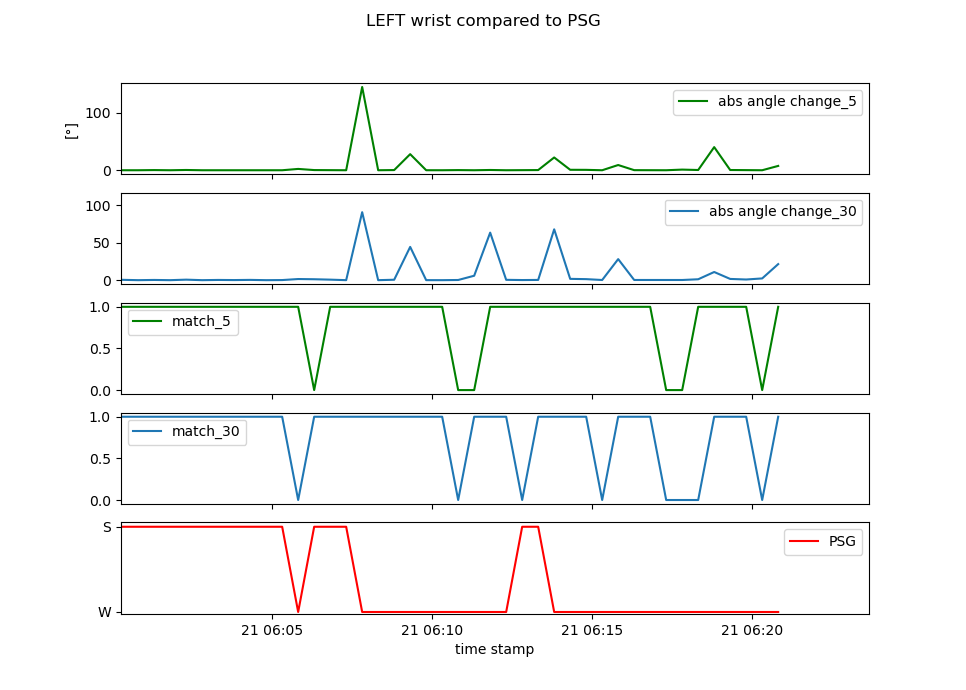

Text(0.5, 0.98, 'LEFT wrist compared to PSG')

Text(0, 0.5, '[°]')

Text(0.5, 0, 'time stamp')

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True)
fig.suptitle('LEFT wrist compared to PSG')

ax1.plot(l_df_res['abs angle change'], label='abs angle change_5', color="Green")
ax2.plot(l_df_res_30['abs angle change'], label='abs angle change_30')
ax3.plot(l_df_res['match'], label='match_5', color="Green")
ax4.plot(l_df_res_30['match'], label='match_30')
ax5.plot(l_df_res['Sleep Stage'], label='PSG', color="Red")

ax1.set_ylabel('[°]')
ax5.set_xlabel('time stamp')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

<IPython.core.display.Javascript object>


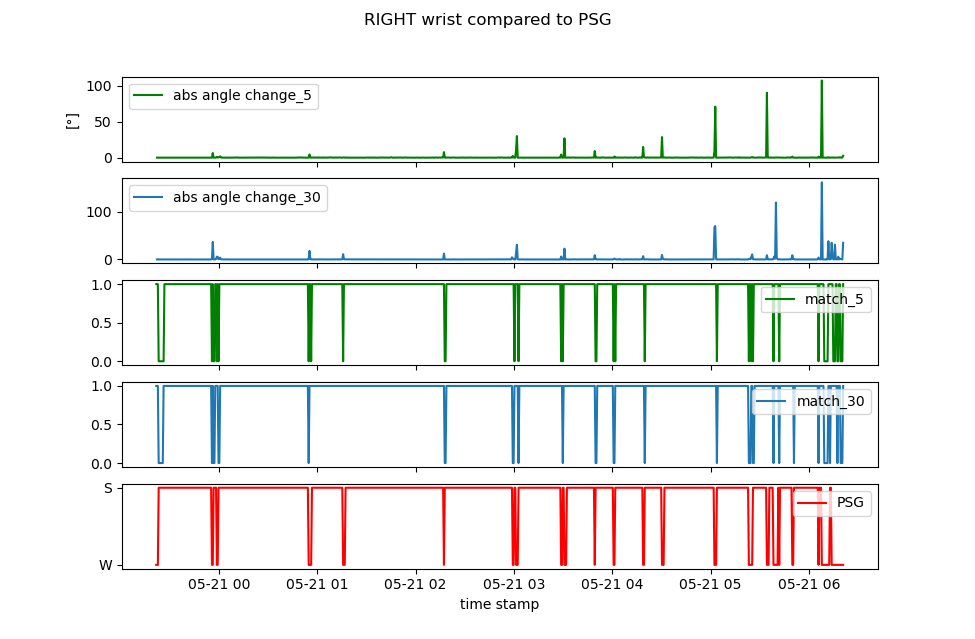

Text(0.5, 0.98, 'RIGHT wrist compared to PSG')

Text(0, 0.5, '[°]')

Text(0.5, 0, 'time stamp')

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True)
fig.suptitle('RIGHT wrist compared to PSG')

ax1.plot(r_df_res['abs angle change'], label='abs angle change_5', color="Green")
ax2.plot(r_df_res_30['abs angle change'], label='abs angle change_30')
ax3.plot(r_df_res['match'], label='match_5', color="Green")
ax4.plot(r_df_res_30['match'], label='match_30')
ax5.plot(r_df_res['Sleep Stage'], label='PSG', color="Red")

ax1.set_ylabel('[°]')
ax5.set_xlabel('time stamp')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

# Write to files

In [23]:
l_returns_path_csv = path + "Aktigrafie\\" + "Result_5s_" + ACG_file_l
l_30_returns_path_csv = path + "Aktigrafie\\" + "Result_30s_" + ACG_file_l

r_returns_path_csv = path + "Aktigrafie\\" + "Result_5s_" + ACG_file_r
r_30_returns_path_csv = path + "Aktigrafie\\" + "Result_30s_" + ACG_file_r

l_df_res.to_csv(l_returns_path_csv)
l_df_res_30.to_csv(l_30_returns_path_csv)

r_df_res.to_csv(r_returns_path_csv)
r_df_res_30.to_csv(r_30_returns_path_csv)